# Bootstrap

In [7]:
# !pip install gdown
# proxy
import os
os.environ["http_proxy"] = "http://proxy.ad.speechpro.com:3128"
os.environ["https_proxy"] = "http://proxy.ad.speechpro.com:3128"
os.environ["ftp_proxy"] = "http://proxy.ad.speechpro.com:3128"

In [8]:
# загрузка данных, необходимых для работы
!gdown --id '1Wkh3C0uW5__8d5j7h8pF8t_OiARoDudj'

/mnt/storage/kocharyan/sambashare/ITMO_LABS/ML/venv/local/lib/python3.8/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Wkh3C0uW5__8d5j7h8pF8t_OiARoDudj
To: /mnt/storage/kocharyan/ASR/day_1.zip
100%|████████████████████████████████████████| 125k/125k [00:00<00:00, 16.7MB/s]


In [9]:
!unzip -q day_1.zip && rm -f day_1/*.ipynb
!rm -rf day_1.zip sample_data
%cd day_1

/mnt/storage/kocharyan/ASR/day_1


# Урок 1

В этом уроке мы научимся извлекать MFCC (и не только) признаки из аудио файла. Для этого необходимо сделать следующее:

1) Загрузить отсчеты и частоту дискретизации wav файла.<br>
2) Посчитать MFCC признаки по полученным выше данным.<br>
3) Записать посчитанные признаки в удобный формат.<br>

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display

from utils import FtrFile

In [13]:
wav_example = 'data/example.wav'

# чтение wav файла:
x, sr = librosa.load(wav_example, sr=None)     # sr=None to preserve the native sampling rate

print('Number of samples: {}'.format(len(x)))
print('Sampling rate: {} Hz'.format(sr))
print('Duration: {:.2f} s'.format(len(x)/sr))  # ~ librosa.get_duration(x, sr)

# воспроизведение:
ipd.Audio(x, rate=sr)

Number of samples: 76800
Sampling rate: 22050 Hz
Duration: 3.48 s


Теперь представим данную запись во временной области.

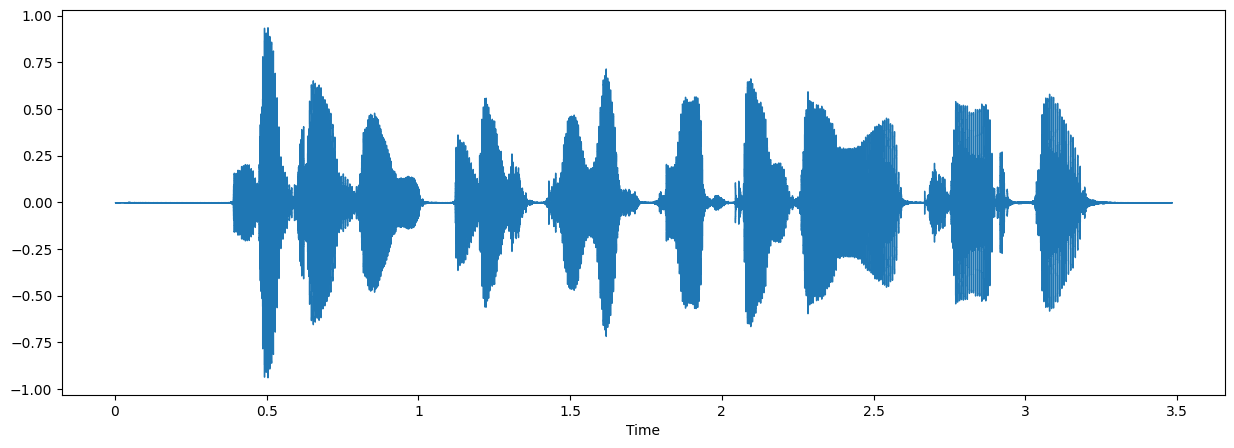

In [16]:
# амплитудная огибающая:

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

librosa.display.waveshow(x, sr=sr);

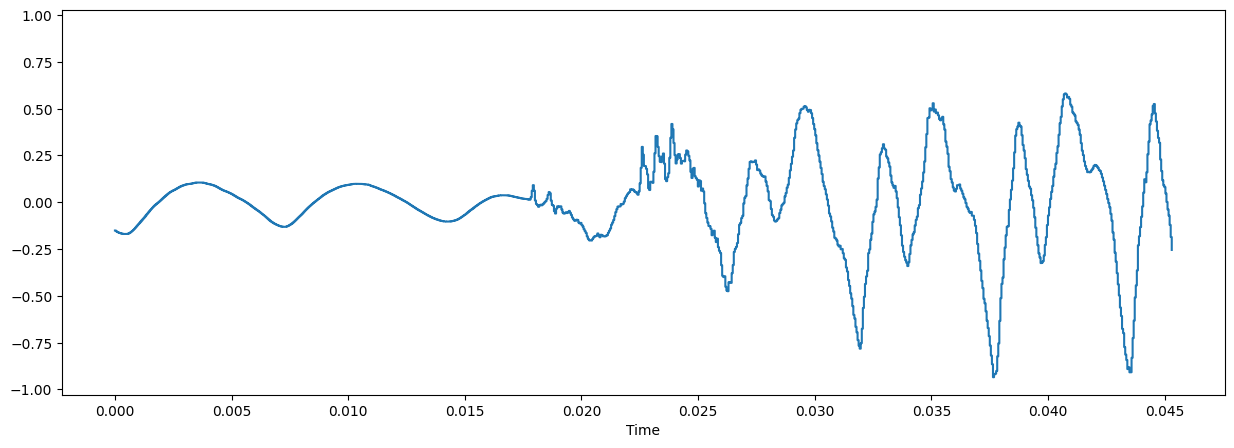

In [34]:
librosa.display.waveshow(x[10000:11000], sr=sr);

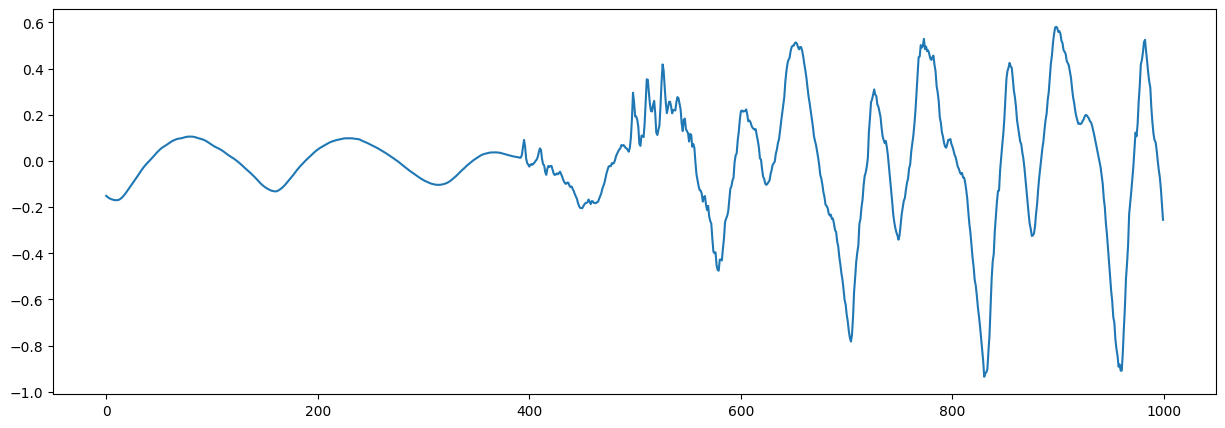

In [22]:
import matplotlib.pyplot as plt

plt.plot(x[10000:11000])
plt.show()

<b>Вопрос 1 (*)</b>. Почему графики отличаются? 

**1**. По оси `x` в случае с `plt.plot` откладываются номера отчетов, а для `librosa.display.waveshow` - время (номер отчета / sr)

**2**. В графиках можно разглядеть различия. `librosa.display.waveshow` использует функцию `matplotlib.pyplot.step` вместо `plt.plot`, и возможно это связано с тем, что цель визуализации - наилучшим образом отобразить дискретные значения амплитуды сигнала (т.е. в данном случае можно сохранить информацию о форме сигнала без сглаживания). Помимо всего прочего, в `librosa` реализовано заполнение области между амплитудными огибающими и осью X, что улучшает читаемость графика и позволяет наглядно представить форму волны звука, однако эта опция используется, когда длина визуализируемого сигнала превышает определенный порог.

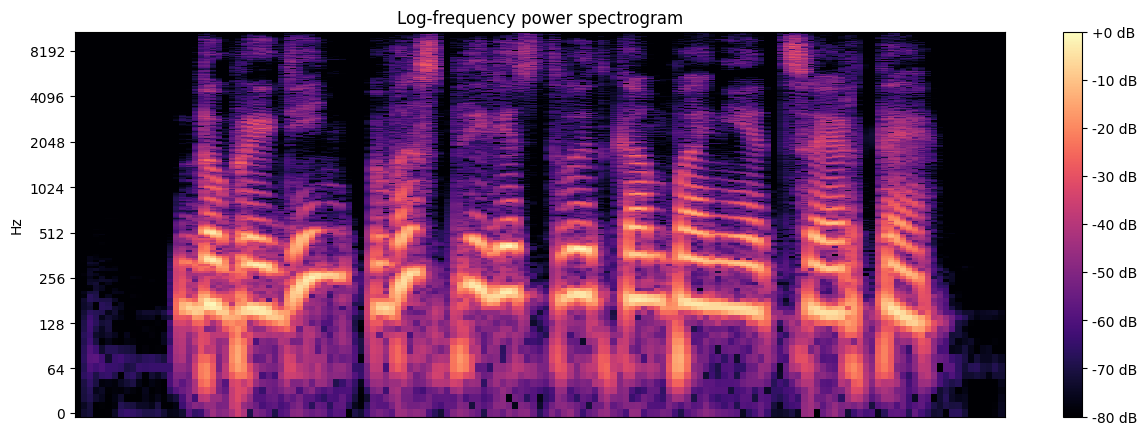

In [36]:
# спектрограмма:

D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)
librosa.display.specshow(D, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram');

### FBANK

In [38]:
# n_fft = 25 ms      -- длина кадра
# hop_length = 10 ms -- длина шага
# тогда в отчетах получаем следующее:

n_fft = int(sr * 0.025)
hop_length = int(sr * 0.01)


fbanks = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=40, n_fft=n_fft, hop_length=hop_length)
print(fbanks.shape)
print(fbanks[:,1])

(40, 350)
[1.27440705e-06 3.46179661e-07 2.43541166e-07 6.76898182e-08
 7.69227384e-08 3.55148941e-08 2.24042260e-08 1.06879163e-08
 7.39732853e-09 1.38720795e-08 7.29286098e-09 3.49612073e-09
 3.59247876e-09 3.18998716e-09 8.87154628e-10 9.98410798e-10
 7.15427717e-10 7.61498253e-10 9.34288868e-10 9.19319509e-10
 5.66223179e-10 7.37538308e-10 7.09664494e-10 2.44458204e-10
 4.49969673e-10 3.93388905e-10 4.77257456e-10 2.59672672e-10
 3.09674647e-10 1.37239400e-10 6.33956915e-11 1.61078997e-10
 1.48551477e-10 1.16072471e-10 1.39162362e-10 1.79737794e-10
 1.59346231e-10 1.38489997e-10 8.22567015e-11 7.54605961e-11]


### MFCC

In [42]:
mfccs = librosa.feature.mfcc(S=librosa.power_to_db(fbanks), n_mfcc=13)
print(mfccs.shape)
print(mfccs[:,1])

(13, 350)
[-401.11996       1.0256704     1.0232975     1.0193468     1.0138228
    1.0067387     0.9981006     0.98792356    0.97621834    0.96301764
    0.94832706    0.9321743     0.9145827 ]


In [43]:
wav_name = wav_example.split('.')[0]
np.save(wav_name, mfccs)

В результате мы получили бинарный файл example.npy, содержащий в себе матрицу с 13-мерными MFCC признаками аудио файла example.wav

Но работать с бинарными файлами не всегда удобно. Мы будем пользоваться общепринятым ark текстовым форматом библиотеки распознавания речи KALDI, где в одном файле будут храниться признаки для всех используемых записей. Он выглядит следующим образом:

file1-identifier [<br>
vec0_0 vec0_1 vec0_2 ... vec0_12<br>
vec1_0 vec1_1 vec1_2 ... vec1_12<br>
....<br>
vecN_0 vecN_1 vecN_2 ... vecN_12<br>
]<br>
file2-identifier [<br>
vec0_0 vec0_1 vec0_2 ... vec0_12<br>
vec1_0 vec1_1 vec1_2 ... vec1_12<br>
....<br>
vecN_0 vecN_1 vecN_2 ... vecN_12<br>
]<br>

Здесь "file1-identifier" – это имя файла, а "vec0_0 vec0_1 vec0_2 ... vec0_12" – вектор MFCC признаков первого (нулевого) кадра записи. 
<br><b>Задание 1</b>. Сохранить нашу матрицу с признаками (features) в указанном формате: 

In [63]:
# запись признаков в формат ark,t:
file_name = wav_name + '.txtftr'
features = mfccs

files2feat = {
    file_name: features,
}

with open(file_name, 'w') as fn:
    for wav_name, features in files2feat.items():
        fn.write(wav_name + ' [\n')
        for vec in features:
            fn.write(' '.join(map(str, vec)))
            fn.write('\n')
        fn.write(']\n')

Для чтения признаков из такого формата мы будем использовать удобную читалку FtrFile. Функция FtrFile.FtrDirectoryReader принимает файл с признаками и возвращает имя файла и класс features, который имеет следующие атрибуты:

- nSamples – количество векторов в фале;<br>
- nDim – размерность вектора признаков;<br>
- readvec() – возвращает очередной вектор признаков;<br>
- getall() – возвращает все признаки текущего файла.<br>

Также, для ее работы необходимо добавлять префикс 'ark,t:' к названию файла с признаками.

Попробуем с ее помощью прочитать наш example.txtftr:

In [64]:
ark_file = 'ark,t:' + file_name
for fileName, features in FtrFile.FtrDirectoryReader(ark_file):
    print('имя файла: {}'.format(fileName))
    print('количество векторов в файле: {}'.format(features.nSamples))
    print('размерность вектора признаков: {}'.format(features.nDim))
    print('вектор признаков первого кадра: {}'.format(features.readvec()))

имя файла: data/example.txtftr
количество векторов в файле: 13
размерность вектора признаков: 350
вектор признаков первого кадра: [-401.45563 -401.11996 -401.84573 -401.84573 -389.81595 -388.6128
 -392.80847 -392.22903 -391.52618 -393.18402 -393.2041  -392.6582
 -397.14322 -395.24673 -396.53296 -395.43695 -397.7931  -398.2079
 -398.1655  -398.76886 -398.57822 -398.02255 -397.7652  -398.48798
 -398.46674 -398.28894 -398.47388 -398.63    -396.94424 -398.36877
 -398.65625 -398.53262 -398.68997 -397.98135 -397.02936 -395.70892
 -396.07935 -396.77615 -369.01276 -312.73645 -296.75696 -291.86966
 -285.84457 -287.70944 -299.932   -302.3377  -306.95526 -172.76482
 -106.03411 -116.72215 -118.88574 -129.6699  -146.31158 -172.5209
 -202.3867  -258.90558 -297.846   -310.14337 -329.49057 -232.28911
 -201.20494 -158.53511 -150.8699  -174.13603 -145.788   -142.2745
 -147.6959  -141.97792 -143.7569  -144.7926  -159.77266 -164.58394
 -191.68655 -228.65375 -289.3732  -315.94684 -322.95795 -331.78662
 -33

Для работы с признаками удобно делать цикл по количеству векторов в файле и в нем уже вызывать features.readvec() для получения признаков текущего кадра. Этим мы займемся в следующем уроке.

На практике бывает полезно нормализовывать признаки.
<br>Есть несколько способов это сделать. Мы рассмотрим т.н. "глобальную" нормализацию, при которой статистики для кадого признака считаются по всей обучающей выборке и в дальшейшем применяются как к обучающей, так и тестовой выборкам.

<b>Задание 2 (*)</b>. Написать функцию подсчёта статистик признаков:
- На вход подаются данные. Флаги контролируют, какие статистики считать.
- На выходе ожидается пара статистик: среднее и дисперсия. Если какая-то статистика не считалась -- поставить на её месте *None*.
- Для удобства дальшейшего использования входные данные считать массивом (если хотите, тензором) размерности (n_utt, seq_len_max, n_feat), т.е. за признаки будет отвечать последняя размерность.

**N.B.** Здесь у нас всего одна запись, но потом их будет больше, так что функцию лучше писать в общем виде.

In [103]:
def compute_cmvn_stats(data, norm_vars=True, norm_means=True):
    
    # if input.shape==(n_utt, seq_len_max, n_feat), 
    # where mfccs.shape==(seq_len_max, n_feat) then
    # mean(var).shape==(n_utt,) (глобальная нормализация)
    
    mean = None
    var = None
    if norm_vars:
        var = np.var(data, axis=(1, 2), keepdims=True)
    if norm_means:
        mean = np.mean(data, axis=(1, 2), keepdims=True)
    
    return (mean, var)

<b>Задание 3 (*)</b>. Написать функцию нормализации признаков:
- На вход подаются данные и пара статистик: среднее и дисперсия. Флаги контролируют, какие статистики использовать.
- На выходе ожидаются нормализованные данные.

In [104]:
def apply_cmvn(data, cmvn, norm_vars=True, norm_means=True):
    
    norm_data = data.copy()
    mean, var = cmvn
    if norm_means:
        norm_data -= mean
    if norm_vars:
        norm_data /= var
    
    return norm_data

In [129]:
# Применительно к аудиосигналу
data = x[np.newaxis, ..., np.newaxis]
cmvn = compute_cmvn_stats(data)
data = apply_cmvn(data, cmvn)
assert data.flatten().shape == x.shape

# Применительно к mfcc
data = mfccs[np.newaxis, ...]
cmvn = compute_cmvn_stats(data)
data = apply_cmvn(data, cmvn)
assert data[0].shape == mfccs.shape

Простые FBANK и MFCC -- это скучно! Есть множество дополнительных признаков, которые могут улучшить качество разпознавания.
<br><b>Задание 4 (**)</b>. Реализовать (или найти и импортнуть) подсчёт каких-нибудь дополнительных фич (pitch, deltas, ...).

**N.B.** Сохранялку матрицы признаков из Задания 1 тоже нужно будет поправить.

Классически, для работы с аудиосигналами используются **MFCC**-признаки, описывающие форму спектральной огибающей и предоставляющие ряд полезной информации:
- моделируют общие и индивидуальные характеристики голоса
- позволяют идентифицировать периодические и резонансные структуры в частотном пространстве звукового сигнала

Однако существует множество признаков, которые могут улучшить качество распознования:
- **Chroma Energy Normalized** (отображает рспределение энергии в кадре сигнала, подходит для сопоставления звука, где присутствуют вариации)
- **Спектограмма** (отображает зависимость спектральной плотности мощности сигнала от времени, современные data-driven подходы на основе нейронных сетей как раз извлекают необходимую информацию именно из нее)
- **Spectral Centroid** (расположение центра масс звука в каждом фрейме сигнала)
- **Spectral Rolloff** (мера формы сигнала)
- **Spectral Contrast** (разница между пиками и впадинами в спектре) и т.д.

In [147]:
def plot_features(audio):
    '''Функция для отображения ...'''
    from sklearn.preprocessing import minmax_scale
    
    plt.rcParams.update({'font.size': 8})

    fig, axs = plt.subplots(2, 3, figsize=(15, 7), sharex=True)

    # загрузка аудио-записи
    signal, sr = librosa.load(audio)
    # разделение гармонических и ударных компонент сигнала
    harmonic, precussive = librosa.effects.hpss(signal)
    display(ipd.Audio(signal, rate=sr))

    ax = axs[1, 1]
    # рассчет Chroma Energy Normalized
    chroma = librosa.feature.chroma_cens(y=harmonic, sr=sr)
    sh = librosa.display.specshow(chroma, ax=ax, y_axis='chroma', x_axis='time')
    fig.colorbar(sh, ax=ax)
    ax.set_title('CENS')

    ax = axs[0, 1]
    # рассчет Мел-кепстральных коэффициентов
    mfccs = librosa.feature.mfcc(y=harmonic, sr=sr, n_mfcc=20)
    sh = librosa.display.specshow(mfccs, ax=ax, x_axis='time')
    fig.colorbar(sh, ax=ax)
    ax.set_title('MFCC')

    ax = axs[0, 2]
    # рассчет Спектограммы
    spec = librosa.stft(signal)
    spec = librosa.amplitude_to_db(abs(spec))
    sh = librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log', ax=ax)
    fig.colorbar(sh, ax=ax)
    ax.set_title('Spectrogram')


    ax = axs[1, 0]
    # рассчет Spectral Rolloff
    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)[0]
    times = librosa.frames_to_time(range(len(spectral_centroid)))
    librosa.display.waveshow(signal, sr=sr, alpha=.5, ax=ax, label='wive')
    ax.plot(times, minmax_scale(spectral_centroid), label='spectral centroid')
    ax.legend()
    ax.set_title('Spectral Centroid')

    ax = axs[0, 0]
    # рассчет Chroma Energy Normalized
    spectral_rolloff = librosa.feature.spectral_rolloff(y=(signal + .01), sr=sr)[0]
    librosa.display.waveshow(precussive, sr=sr, alpha=.4, ax=ax, label='precussive')
    librosa.display.waveshow(harmonic, sr=sr, alpha=.4, ax=ax, label='harmonic')
    ax.plot(times, minmax_scale(spectral_rolloff), label='rolloff')
    ax.legend()
    ax.set_title('Spectral Rolloff')

    ax = axs[1, 2]
    # рассчет Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=harmonic, sr=sr)
    sh = librosa.display.specshow(contrast, x_axis='time', ax=ax)
    fig.colorbar(sh, ax=ax)
    ax.set_ylabel('Freq bands')
    ax.set_title('Spectral Contrast')

    plt.show();

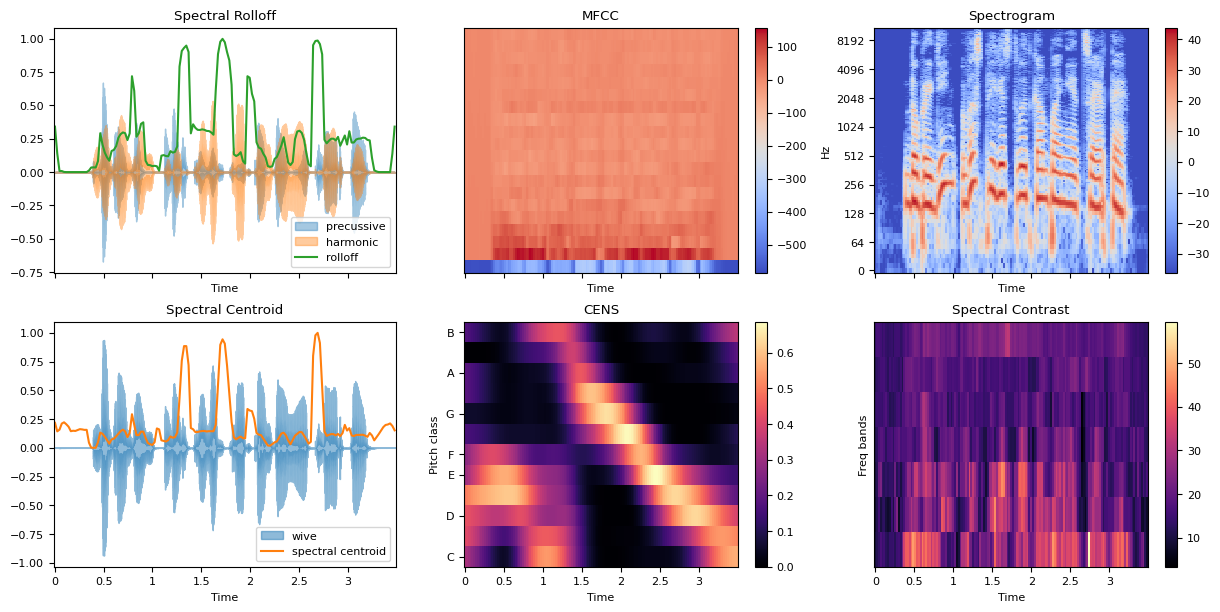

In [148]:
plot_features(wav_example)